# Pricing Down-and-In Barrier European Call Option in the Heston Model

## Change working directory to navigate out of folder. 

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

## Load Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
import pandas as pd
from IPython.display import display, HTML
import QuantLib as ql
from sklearn.metrics import mean_squared_error
from torch import nn
import torch.cuda
from collections import defaultdict

from MMD.mmd import RBFKernel, SigKernel

from GenerateMMDDataset.mmd_dataset_base import save_dataset, load_dataset, save_path_params, load_path_params

from StochasticModels.heston_model import  heston_sample_paths, heston_sample_paths_inv

from RegressionModel.pricing_model import PricingModel
from RegressionModel.mmd_model import SecondOrderMMDApprox

from utils.plotting_functions import construct_scatter_plot

## Set PyTorch Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.backends.cudnn.benchmark = True

Device: cuda


## Down-and-In Barrier Option Payoff

In [4]:
def european_call_monte_carlo_disc(S1, r, K, T):
    '''
    Compute the price of a donw-and-in barrier European call option using Monte Carlo.
    :param S1: Asset price at maturity. It is K if barrier breached. 
    :param r: Risk-free interest rate.
    :param K: Strike.
    :param T: Maturity.
    :return: Barrier option price. 
    '''
    
    return np.mean(np.multiply(np.exp(-r*T), np.maximum(0, S1 - K)))

In [5]:
def quantlib_barrier_heston_price(S0, K, r, barrier, v0, mean_volatility, speed, vol_of_vol, correlation, T,
                                  dividend=0, rebate=0., barrierType=ql.Barrier.DownIn, t = None):
    
    '''
    Compute the price of a European Call Option using Monte Carlo.
    :param S0: Asset price at maturity.
    :param K: Strike.
    :param r: Risk-free interest rate.
    :param v0: Initial volatility.
    :param mean_volatility: Long-term variance.
    :param speed: Speed of mean-reversion.  
    :param vol_of_vol: Volatility of the volatility. 
    :param correlation: Correlation. 
    :param T: Maturity. 
    :param divident: Dividend. Default is 0. 
    :param rebate: Rebate. Default is 0.
    :param barrierType: Default is ql.Barrier.DownIn.
    :return: barrier price. 
    '''

    option_type = ql.Option.Call

    call_payoff = ql.PlainVanillaPayoff(option_type, K)

    day_count = ql.Actual365Fixed()

    today = ql.Date().todaysDate()
    maturity = today + ql.Period(f"{T*365}d")
    call_exercise = ql.EuropeanExercise(maturity)
    
    variance = v0

    spot = ql.SimpleQuote(S0)

    initial_value = ql.QuoteHandle(spot)

    discount_curve = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today, dividend, day_count))

    heston_process = ql.HestonProcess(discount_curve, dividend_yield, initial_value,
                                      variance, speed, mean_volatility, vol_of_vol, correlation)
    
    if S0 >= barrier:
        barrierOption = ql.BarrierOption(barrierType, barrier, rebate, call_payoff, call_exercise)

        engine = ql.FdHestonBarrierEngine(ql.HestonModel(heston_process))

        barrierOption.setPricingEngine(engine)
        price = barrierOption.NPV()
        
    else:
        
        european_option = ql.VanillaOption(call_payoff, call_exercise)
        engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process), 0.01, 1000)
        european_option.setPricingEngine(engine)
        price = european_option.NPV()
        
        
    return price

## Load Pre-trained MMD model. 

In [6]:
heston_mmd_input_dimension = 10

heston_mmd_model_param_dict = {
    'input_dimension' : heston_mmd_input_dimension,
    'intermediate_dimensions' : [50, 50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None
}

heston_second_order_mmd_model = SecondOrderMMDApprox(heston_mmd_model_param_dict,
                                                     None,
                                                     None,
                                                     None, 
                                                     device,
                                                     None)

heston_second_order_mmd_model.load_best_model('Heston/MMD Model/heston_mmd_model_best_1.pth.tar', 
                                              'Heston/MMD Model/heston_mmd_scaler_1.pkl')

## Generate dataset. 

In [8]:
vol_of_vol_range = (0.2, 0.5)
mean_volatility_range = (0.2, 0.5)
_round = 5
speed_range = (0.2, 0.5)
v0_range = (0.2, 0.5)

S0_range = (50, 80)
strike_range = (40, 90)
r_range = (0.01, 0.1)
r_round = 5

heston_num_sim = 20000
heston_num_time_steps = 50

M = 50000
N = 20

T_range = (0.1, 3.0)

vol_of_vols = np.round(np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1], M), _round)
speeds = np.round(np.random.uniform(speed_range[0], speed_range[1], M), _round)
mean_volatilities = np.round(np.random.uniform(mean_volatility_range[0], mean_volatility_range[1], M), _round)
correlations = np.round(np.random.uniform(-1, 1, M), _round)
initial_vols = np.round(np.random.uniform(v0_range[0], v0_range[1], M), _round)
S0_heston = np.random.randint(S0_range[0], S0_range[1], M)
r_heston = np.round(np.random.uniform(r_range[0], r_range[1], M), r_round)
strike_heston = np.random.randint(strike_range[0], strike_range[1], M)
T_list = np.random.choice([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0], M)
barrier_heston = []


heston_down_in_call_barrier_pricing_features = []
heston_down_in_call_barrier_pricing_labels = []
heston_second_order_mmd_model.model.eval()
with torch.no_grad():
    for i in tqdm(range(M)):
        correlation = correlations[i]
        mean_volatility = mean_volatilities[i]
        speed = speeds[i]
        vol_of_vol = vol_of_vols[i]
        r = r_heston[i]
        v0 = initial_vols[i]
        T = T_list[i]
        S0 = S0_heston[i]
        strike = strike_heston[i]
        barrier = np.random.randint(S0-25, S0-5)
        barrier_heston.append(barrier)
        
        new_features = [heston_second_order_mmd_model.transform(torch.tensor([
                                v0, initial_vols[j],
                                vol_of_vol, vol_of_vols[j], 
                                mean_volatility, mean_volatilities[j],
                                speed, speeds[j],
                                correlation, correlations[j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                        for j in range(N)]
        new_features += [S0, strike, r, barrier, T]

        heston_down_in_call_barrier_pricing_features.append(new_features)
        
        heston_down_in_call_barrier_pricing_labels.append(quantlib_barrier_heston_price(float(S0), float(strike), r,
                                                                                        float(barrier), v0,
                                                                                        mean_volatility, speed,
                                                                                        vol_of_vol, correlation, T))


  0%|          | 0/50000 [00:00<?, ?it/s]

### Save the Dataset

In [15]:
length = len(heston_down_in_call_barrier_pricing_features)
l = int(length/5)
sub_features = []
for i in range(5):
    sub_features.append(heston_down_in_call_barrier_pricing_features[i*l:(i+1)*l])
    
features_file_name_base = "Heston/Data/heston_down_in_call_barrier_pricing_features_diff_T_quantlib"

for i in range(5):
    with open(f'{features_file_name_base}_part_{i+1}', "wb") as fp:
        pickle.dump(sub_features[i], fp)

labels_file_name = "Heston/Data/heston_down_in_call_barrier_pricing_labels_diff_T_quantlib"
dict_file_name = "Heston/Data/heston_down_in_call_barrier_pricing_dict_diff_T_quantlib"
    
    
with open(labels_file_name, "wb") as fp:
    pickle.dump(heston_down_in_call_barrier_pricing_labels, fp)
    

heston_down_in_call_barrier_pricing_dict = {}

heston_down_in_call_barrier_pricing_dict['S0'] = S0_heston
heston_down_in_call_barrier_pricing_dict['S0 Range'] = S0_range
heston_down_in_call_barrier_pricing_dict['Strikes'] = strike_heston
heston_down_in_call_barrier_pricing_dict['Strike Range'] = strike_range
heston_down_in_call_barrier_pricing_dict['r'] = r_heston
heston_down_in_call_barrier_pricing_dict['r Range'] = r_range
heston_down_in_call_barrier_pricing_dict['r round'] = r_round
heston_down_in_call_barrier_pricing_dict['Heston MC Num Sim'] = heston_num_sim
heston_down_in_call_barrier_pricing_dict['Heston MC Num Time Steps'] = heston_num_time_steps
heston_down_in_call_barrier_pricing_dict['Vol of Vols'] = vol_of_vols
heston_down_in_call_barrier_pricing_dict['Vol of Vol Range'] = vol_of_vol_range
heston_down_in_call_barrier_pricing_dict['Speeds'] = speeds
heston_down_in_call_barrier_pricing_dict['Speed Range'] = speed_range
heston_down_in_call_barrier_pricing_dict['Mean Volatilities'] = mean_volatilities
heston_down_in_call_barrier_pricing_dict['Mean Volatility Range'] = mean_volatility_range
heston_down_in_call_barrier_pricing_dict['Correlations'] = correlations
heston_down_in_call_barrier_pricing_dict['M'] = M
heston_down_in_call_barrier_pricing_dict['N'] = N
heston_down_in_call_barrier_pricing_dict['V0 Range'] = v0_range
heston_down_in_call_barrier_pricing_dict['V0 List'] = initial_vols
heston_down_in_call_barrier_pricing_dict['Barriers'] = barrier_heston
heston_down_in_call_barrier_pricing_dict['T'] = T_list
heston_down_in_call_barrier_pricing_dict['T Range'] = T_range


save_path_params(heston_down_in_call_barrier_pricing_dict, dict_file_name)

### Load the Dataset

In [6]:
features_file_name_base = "Heston/Data/heston_down_in_call_barrier_pricing_features_diff_T_quantlib"
heston_down_in_call_barrier_pricing_features = []

for i in range(5):
    with open(f'{features_file_name_base}_part_{i+1}', 'rb') as f:
            heston_down_in_call_barrier_pricing_features += pickle.load(f)

labels_file_name = "Heston/Data/heston_down_in_call_barrier_pricing_labels_diff_T_quantlib"
        
with open(labels_file_name, 'rb') as f:
        heston_down_in_call_barrier_pricing_labels = pickle.load(f)

In [11]:
dict_file_name = "Heston/Data/heston_down_in_call_barrier_pricing_dict_diff_T_quantlib"
heston_down_in_call_barrier_pricing_dict = load_path_params(dict_file_name)

### Train the model. 

In [ ]:
for k in [1, 5, 10, 15, 20]:
    
    heston_barrier_training_param_dict_1_dist = {
    'lr' : 0.005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
    }


    heston_barrier_dataset_loader_params_1_dist = {
        'batch_size' : 256,
        'shuffle' : True,
        'num_workers' : 0
    }

    heston_barrier_input_dimension_1_dist = k+5

    heston_barrier_model_param_dict_1_dist = {
        'input_dimension' : heston_barrier_input_dimension_1_dist,
        'intermediate_dimensions' : [75, 75, 75, 75],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
        'add_layer_norm' : [False, False, False, False, False], 
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : False,
        'use_residual' : False
    }


    for i in range(5):

        barrier_pricing_model_heston_1_dist = PricingModel(heston_barrier_model_param_dict_1_dist, 
                                                       heston_barrier_training_param_dict_1_dist,
                                                       heston_barrier_dataset_loader_params_1_dist,
                                                       nn.MSELoss(),
                                                       device, 
                                                       f'Heston/Down-In Barrier Pricer/heston_barrier_scaler_diff_T_quantlib_{k}_dist_{i+1}.pkl',
                                                       heston_barrier_input_dimension_1_dist, 
                                                       scheduler_gamma=0.75,
                                                       use_scheduler=True,
                                                       milestones=[50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155,
                                                                   160, 165, 170, 175, 180, 185, 190, 195])

        barrier_pricing_model_heston_1_dist.fit(torch.tensor(heston_down_in_call_barrier_pricing_features)[:, 20-k:].float(), 
                                     torch.tensor(heston_down_in_call_barrier_pricing_labels).float(), 
                                     **{'filename' : f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_checkpoint_diff_T_quantlib_{k}_dist_{i+1}.pth.tar', 
                                        'best_model_filename' : f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_{k}_dist_{i+1}.pth.tar'})

In [13]:
train_losses_dict = defaultdict(list)

for k in [1, 5, 10, 15, 20]:
    
    for i in range(5):
        checkpoint = torch.load(f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_{k}_dist_{i+1}.pth.tar', map_location='cpu')
        train_losses_dict[k].append(checkpoint['train_loss'])
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(train_losses_dict[k]))
    print(np.std(train_losses_dict[k]))

********************  1 ********************
0.40375139713287356
0.005374824605318147
********************  5 ********************
0.03691261932253838
0.0012653511856037527
********************  10 ********************
0.015319139510393143
0.0008933905815103054
********************  15 ********************
0.010703961364924908
0.0004686114458295279
********************  20 ********************
0.008972258120775223
0.0006461639022632713


In [16]:
valid_losses_dict = defaultdict(list)

for k in [1, 5, 10, 15, 20]:
    
    for i in range(5):
        checkpoint = torch.load(f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_{k}_dist_{i+1}.pth.tar', map_location='cpu')
        valid_losses_dict[k].append(checkpoint['valid_loss'])
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(valid_losses_dict[k]))
    print(np.std(valid_losses_dict[k]))

********************  1 ********************
0.4133871288108826
0.007365687123810863
********************  5 ********************
0.043351371092796326
0.0009781271842380648
********************  10 ********************
0.01895658995449543
0.0010272005020151905
********************  15 ********************
0.013881616749167441
0.0006482845082347209
********************  20 ********************
0.011383417294621468
0.0006885732974393438


### Train Basline

In [ ]:
heston_barrier_training_param_dict_no_dist = {
    'lr' : 0.005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


heston_barrier_dataset_loader_params_no_dist = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}

heston_barrier_input_dimension_no_dist = 10

heston_barrier_model_param_dict_no_dist = {
    'input_dimension' : heston_barrier_input_dimension_no_dist,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}



S0_heston = heston_down_in_call_barrier_pricing_dict['S0']
r_heston = heston_down_in_call_barrier_pricing_dict['r']
strike_heston = heston_down_in_call_barrier_pricing_dict['Strikes']
T_list = heston_down_in_call_barrier_pricing_dict['T']
barrier_heston = heston_down_in_call_barrier_pricing_dict['Barriers']
initial_vols = heston_down_in_call_barrier_pricing_dict['V0 List']
vol_of_vols = heston_down_in_call_barrier_pricing_dict['Vol of Vols']
mean_volatilities = heston_down_in_call_barrier_pricing_dict['Mean Volatilities']
speeds = heston_down_in_call_barrier_pricing_dict['Speeds']
correlations = heston_down_in_call_barrier_pricing_dict['Correlations']

features = []
for i in range(len(heston_down_in_call_barrier_pricing_features)):
    features.append([vol_of_vols[i], speeds[i], mean_volatilities[i], correlations[i], initial_vols[i], S0_heston[i], strike_heston[i], barrier_heston[i], r_heston[i], T_list[i]])

for i in range(5):
    
    barrier_pricing_model_heston_no_dist = PricingModel(heston_barrier_model_param_dict_no_dist,
                                                    heston_barrier_training_param_dict_no_dist,
                                                    heston_barrier_dataset_loader_params_no_dist, nn.MSELoss(), device, 
                                                    f'Heston/Down-In Barrier Pricer/heston_barrier_scaler_diff_T_quantlib_no_distances_v2_{i+1}.pkl',
                                                    5, scheduler_gamma=0.75, use_scheduler=True,
                                                    milestones=[50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155,
                                                                160, 165, 170, 175, 180, 185, 190, 195])
    
    
    barrier_pricing_model_heston_no_dist.fit(torch.tensor(features).float(), 
                             torch.tensor(heston_down_in_call_barrier_pricing_labels).float(), 
                             **{'filename' : f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_checkpoint_diff_T_quantlib_distances_{i+1}.pth.tar', 
                                'best_model_filename' : f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_no_distances_{i+1}.pth.tar'})

In [20]:
train_losses = []
valid_losses = []
    
for i in range(5):
    checkpoint = torch.load(f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_no_distances_{i+1}.pth.tar', map_location='cpu')
    train_losses.append(checkpoint['train_loss'])
    valid_losses.append(checkpoint['valid_loss'])

print(f'Training Loss')
print(np.mean(train_losses))
print(np.std(train_losses))
print(f'Validation Loss')
print(np.mean(valid_losses))
print(np.std(valid_losses))

Training Loss
0.011885972693562508
0.000865799281685034
Validation Loss
0.01264427714049816
0.0009380975529618547


## Test the Model

In [13]:
vol_of_vol_range = (0.2, 0.5)
mean_volatility_range = (0.2, 0.5)
_round = 5
speed_range = (0.2, 0.5)
v0_range = (0.2, 0.5)

S0_range = (50, 80)
strike_range = (40, 90)
r_range = (0.01, 0.1)
r_round = 5

heston_num_sim = 20000
heston_num_time_steps = 50

M = 2000
N = 20

T_range = (0.1, 3.0)

vol_of_vols = np.round(np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1], M), _round)
speeds = np.round(np.random.uniform(speed_range[0], speed_range[1], M), _round)
mean_volatilities = np.round(np.random.uniform(mean_volatility_range[0], mean_volatility_range[1], M), _round)
correlations = np.round(np.random.uniform(-1, 1, M), _round)
initial_vols = np.round(np.random.uniform(v0_range[0], v0_range[1], M), _round)
S0_heston = np.random.randint(S0_range[0], S0_range[1], M)
r_heston = np.round(np.random.uniform(r_range[0], r_range[1], M), r_round)
strike_heston = np.random.randint(strike_range[0], strike_range[1], M)
T_list = np.random.choice([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0], M)
barrier_heston = []


heston_down_in_call_barrier_pricing_features = []
heston_down_in_call_barrier_pricing_labels = []
heston_second_order_mmd_model.model.eval()
with torch.no_grad():
    for i in tqdm(range(M)):
        correlation = correlations[i]
        mean_volatility = mean_volatilities[i]
        speed = speeds[i]
        vol_of_vol = vol_of_vols[i]
        r = r_heston[i]
        v0 = initial_vols[i]
        T = T_list[i]
        S0 = S0_heston[i]
        strike = strike_heston[i]
        barrier = np.random.randint(S0-25, S0-5)
        barrier_heston.append(barrier)
        
        new_features = [heston_second_order_mmd_model.transform(
            torch.tensor([v0, heston_down_in_call_barrier_pricing_dict['V0 List'][j],
                          vol_of_vol, heston_down_in_call_barrier_pricing_dict['Vol of Vols'][j], 
                          mean_volatility, heston_down_in_call_barrier_pricing_dict['Mean Volatilities'][j],
                          speed, heston_down_in_call_barrier_pricing_dict['Speeds'][j],
                          correlation, heston_down_in_call_barrier_pricing_dict['Correlations'][j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                        for j in range(N)]
        
        new_features += [S0, strike, r, barrier, T]

        heston_down_in_call_barrier_pricing_features.append(new_features)
        
        heston_down_in_call_barrier_pricing_labels.append(quantlib_barrier_heston_price(float(S0), float(strike), r,
                                                                                        float(barrier), v0,
                                                                                        mean_volatility, speed,
                                                                                        vol_of_vol, correlation, T))

  0%|          | 0/2000 [00:00<?, ?it/s]

### SPEEDRS

In [15]:
test_losses_dict = defaultdict(list)



for k in [1, 5, 10, 15, 20]:
    
    input_dimension = k+5

    architecture = {
        'input_dimension' : input_dimension,
        'intermediate_dimensions' : [75, 75, 75, 75],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
        'add_layer_norm' : [False, False, False, False, False], 
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : False,
        'use_residual' : False
    }
    
    barrier_pricing_model_heston = PricingModel(architecture,
                                                None,
                                                None,
                                                None,
                                                device, 
                                                None,
                                                input_dimension)
    
        
    for i in range(5):            
           
        barrier_pricing_model_heston.load_best_model(f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_{k}_dist_{i+1}.pth.tar', 
                                                     f'Heston/Down-In Barrier Pricer/heston_barrier_scaler_diff_T_quantlib_{k}_dist_{i+1}.pkl')

        features = torch.tensor(heston_down_in_call_barrier_pricing_features).float()[:, 20-k:]
        barrier_pricing_model_heston.model.eval()
        with torch.no_grad():
            test_losses_dict[k].append(mean_squared_error(barrier_pricing_model_heston.transform(features).cpu(), heston_down_in_call_barrier_pricing_labels))
        
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(test_losses_dict[k]))
    print(np.std(test_losses_dict[k]))

********************  1 ********************
0.4241845497179256
0.001208048138091286
********************  5 ********************
0.04213574537173488
0.0007325296938845856
********************  10 ********************
0.018834266561668873
0.000710506819931007
********************  15 ********************
0.013418301393930554
0.000577492651808281
********************  20 ********************
0.010564632387017204
0.00037791784510548496


### Baseline

In [25]:
input_dimension = 10

architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}



features = []
for i in range(len(heston_down_in_call_barrier_pricing_features)):
    features.append([vol_of_vols[i], speeds[i], mean_volatilities[i], correlations[i], initial_vols[i], S0_heston[i], strike_heston[i], barrier_heston[i], r_heston[i], T_list[i]])
    

features = np.asarray(features)
test_losses = []

for i in range(5):
    
    barrier_pricing_model_heston = PricingModel(architecture,
                                                None,
                                                None,
                                                None,
                                                device, 
                                                None,
                                                5)


    barrier_pricing_model_heston.load_best_model(f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_no_distances_{i+1}.pth.tar', 
                                                 f'Heston/Down-In Barrier Pricer/heston_barrier_scaler_diff_T_quantlib_no_distances_{i+1}.pkl')

    
    barrier_pricing_model_heston.model.eval()
    with torch.no_grad():
        test_losses.append(mean_squared_error(barrier_pricing_model_heston.transform(torch.tensor(features).float()).cpu(), heston_down_in_call_barrier_pricing_labels))
        
print(np.mean(test_losses))
print(np.std(test_losses))

0.01311282485227273
0.0010532257316568613


### SPEEDRS - Out of Sample Tests

In [7]:
input_dimension = 25

architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [75, 75, 75, 75],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}

barrier_pricing_model_heston = PricingModel(architecture,
                                            None,
                                            None,
                                            None,
                                            device, 
                                            None,
                                            input_dimension)


barrier_pricing_model_heston.load_best_model(f'Heston/Down-In Barrier Pricer/heston_barrier_pricer_model_best_diff_T_quantlib_20_dist_1.pth.tar', 
                                             f'Heston/Down-In Barrier Pricer/heston_barrier_scaler_diff_T_quantlib_20_dist_1.pkl')


dict_file_name = "Heston/Data/heston_down_in_call_barrier_pricing_dict_diff_T_quantlib"
heston_down_in_call_barrier_pricing_dict = load_path_params(dict_file_name)

test_data_dict = {}

Vary $K$ and keep all other parameters fixed. 

In [8]:
vol_of_vol = 0.45
mean_volatility = 0.4
speed = 0.3
r = 0.015
correlation = -0.7
barrier = 60
s0 = 65
v0 = 0.23

T=1


strikes = [i for i in range(30, 100)]


approximate_prices = []

strike_quantlib_prices = []


heston_second_order_mmd_model.model.eval()
with torch.no_grad():
    test_inputs = [heston_second_order_mmd_model.transform(torch.tensor([
                                    v0, heston_down_in_call_barrier_pricing_dict['V0 List'][j],
                                    vol_of_vol, heston_down_in_call_barrier_pricing_dict['Vol of Vols'][j], 
                                    mean_volatility, heston_down_in_call_barrier_pricing_dict['Mean Volatilities'][j],
                                    speed, heston_down_in_call_barrier_pricing_dict['Speeds'][j],
                                    correlation, heston_down_in_call_barrier_pricing_dict['Correlations'][j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                            for j in range(heston_down_in_call_barrier_pricing_dict['N'])]


for strike in tqdm(strikes):
                
    
    strike_quantlib_prices.append(quantlib_barrier_heston_price(s0, strike, r, barrier, v0, mean_volatility, speed, vol_of_vol,
                                                   correlation, T))
    
    barrier_pricing_model_heston.model.eval()
    with torch.no_grad():
        test_inputs += [s0, strike, r, barrier, T]
        approximate_price = barrier_pricing_model_heston.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price.cpu().item())
        
    
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]

results_df = pd.DataFrame({r'Strike' : strikes, 
                           'Price NN' : approximate_prices, 
                           'QuantLib' : strike_quantlib_prices})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'),
                            torch.tensor(strike_quantlib_prices).to(device='cpu'))
print(f'MSE NN: {mse_nn}')


test_data_dict['Strike'] = [strikes, approximate_prices, strike_quantlib_prices]

  0%|          | 0/70 [00:00<?, ?it/s]

,Strike,Price NN,QuantLib
0,30,26.004353,27.493423
1,31,25.402906,26.749136
2,32,24.800951,26.013898
3,33,24.198730,25.287979
4,34,23.596512,24.571629
5,35,22.994293,23.865114
6,36,22.392073,23.168708
7,37,21.789856,22.482638
8,38,21.193077,21.807134
9,39,20.602755,21.142401


MSE NN: 0.15892811119556427


Vary $B$ and keep all other parameters fixed.

In [9]:
vol_of_vol = 0.37
mean_volatility = 0.43
speed = 0.47
r = 0.067
correlation = 0.25
barrier_list = list(range(30, 79))
s0 = 80
v0 = 0.32
strike = 87

T = 2.75


approximate_prices = []


barrier_quantlib_prices = []


heston_second_order_mmd_model.model.eval()
with torch.no_grad():
    test_inputs = [heston_second_order_mmd_model.transform(torch.tensor([
                                    v0, heston_down_in_call_barrier_pricing_dict['V0 List'][j],
                                    vol_of_vol, heston_down_in_call_barrier_pricing_dict['Vol of Vols'][j], 
                                    mean_volatility, heston_down_in_call_barrier_pricing_dict['Mean Volatilities'][j],
                                    speed, heston_down_in_call_barrier_pricing_dict['Speeds'][j],
                                    correlation, heston_down_in_call_barrier_pricing_dict['Correlations'][j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                            for j in range(heston_down_in_call_barrier_pricing_dict['N'])]


for barrier in tqdm(barrier_list):
                

    barrier_quantlib_prices.append(quantlib_barrier_heston_price(s0, strike, r, barrier, v0, mean_volatility, speed, vol_of_vol,
                                                   correlation, T))
    
    barrier_pricing_model_heston.model.eval()
    with torch.no_grad():
        test_inputs += [s0, strike, r, barrier, T]
        approximate_price = barrier_pricing_model_heston.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price.cpu().item())
        
    
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]
    del test_inputs[-1]

results_df = pd.DataFrame({r'Barrier' : barrier_list, 
                           'Price NN' : approximate_prices, 
                           'QuantLib Price' : barrier_quantlib_prices})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), 
                            torch.tensor(barrier_quantlib_prices).to(device='cpu'))
print(f'MSE NN: {mse_nn}')

test_data_dict['Barrier'] = [barrier_list, approximate_prices, barrier_quantlib_prices]

  0%|          | 0/49 [00:00<?, ?it/s]

,Barrier,Price NN,QuantLib Price
0,30,0.999474,0.745463
1,31,1.143132,0.864608
2,32,1.303746,0.998034
3,33,1.465807,1.146607
4,34,1.633424,1.311168
5,35,1.822104,1.492627
6,36,2.012075,1.691750
7,37,2.188070,1.909347
8,38,2.358085,2.146195
9,39,2.535078,2.402991


MSE NN: 0.022623620927333832


Vary the volatility of the volatility ($\xi$) and keep other parameters fixed. 

In [10]:
mean_volatility = 0.48
v0 = 0.36
speed = 0.47
r = 0.067
correlation = -0.34
barrier = 65
s0 = 70
vol_of_vol_list = np.round(np.linspace(0.2, 0.5, 20), 2)
strike = 85

T=2.0


approximate_prices = []

vol_of_vol_quantlib_prices_barrier = []

for vol_of_vol in tqdm(vol_of_vol_list):
                

    vol_of_vol_quantlib_prices_barrier.append(quantlib_barrier_heston_price(s0, strike, r, barrier, v0, mean_volatility, speed, vol_of_vol,
                                                   correlation, T))
    
    heston_second_order_mmd_model.model.eval()
    barrier_pricing_model_heston.model.eval()
    with torch.no_grad():
        test_inputs = [heston_second_order_mmd_model.transform(torch.tensor([
                                v0, heston_down_in_call_barrier_pricing_dict['V0 List'][j],
                                vol_of_vol, heston_down_in_call_barrier_pricing_dict['Vol of Vols'][j], 
                                mean_volatility, heston_down_in_call_barrier_pricing_dict['Mean Volatilities'][j],
                                speed, heston_down_in_call_barrier_pricing_dict['Speeds'][j],
                                correlation, heston_down_in_call_barrier_pricing_dict['Correlations'][j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                        for j in range(heston_down_in_call_barrier_pricing_dict['N'])]
        test_inputs += [s0, strike, r, barrier, T]
        approximate_price = barrier_pricing_model_heston.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price.cpu().item())
        


results_df = pd.DataFrame({r'Vol of Vol' : vol_of_vol_list, 
                           'Price NN' : approximate_prices, 
                           'QuantLib Price' : vol_of_vol_quantlib_prices_barrier})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), 
                            torch.tensor(vol_of_vol_quantlib_prices_barrier).to(device='cpu'))
print(f'MSE NN: {mse_nn}')

test_data_dict['VolofVol'] = [vol_of_vol_list, approximate_prices, vol_of_vol_quantlib_prices_barrier]

  0%|          | 0/20 [00:00<?, ?it/s]

,Vol of Vol,Price NN,QuantLib Price
0,0.20,17.270573,17.352324
1,0.22,17.245775,17.300980
2,0.23,17.236897,17.274613
3,0.25,17.196558,17.220563
4,0.26,17.155231,17.192869
5,0.28,17.060951,17.136197
6,0.29,17.009335,17.107216
7,0.31,16.922112,17.048001
8,0.33,16.859264,16.987277
9,0.34,16.840786,16.956262


MSE NN: 0.01794460229575634


Vary $\rho$ and keep other parameters fixed. 

In [11]:
mean_volatility = 0.25
v0 = 0.35
vol_of_vol = 0.47
speed = 0.34
r = 0.017
barrier = 60
s0 = 70
correlation_list = np.round(np.linspace(-1, 1, 50), 2)
strike = 65

T=2.75


approximate_prices = []


correlation_quantlib_prices_barrier = []


for correlation in tqdm(correlation_list):
                

    correlation_quantlib_prices_barrier.append(quantlib_barrier_heston_price(s0, strike, r, barrier, v0, mean_volatility, speed, vol_of_vol,
                                                   correlation, T))
    
    heston_second_order_mmd_model.model.eval()
    barrier_pricing_model_heston.model.eval()
    with torch.no_grad():
        test_inputs = [heston_second_order_mmd_model.transform(torch.tensor([
                                v0, heston_down_in_call_barrier_pricing_dict['V0 List'][j],
                                vol_of_vol, heston_down_in_call_barrier_pricing_dict['Vol of Vols'][j], 
                                mean_volatility, heston_down_in_call_barrier_pricing_dict['Mean Volatilities'][j],
                                speed, heston_down_in_call_barrier_pricing_dict['Speeds'][j],
                                correlation, heston_down_in_call_barrier_pricing_dict['Correlations'][j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                        for j in range(heston_down_in_call_barrier_pricing_dict['N'])]
        test_inputs += [s0, strike, r, barrier, T]
        approximate_price = barrier_pricing_model_heston.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price.cpu().item())
        


results_df = pd.DataFrame({r'Correlation' : correlation_list, 
                           'Price NN' : approximate_prices, 
                           'QuantLib Price' : correlation_quantlib_prices_barrier})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), torch.tensor(correlation_quantlib_prices_barrier).to(device='cpu'))

print(f'MSE NN: {mse_nn}')

test_data_dict['Correlation'] = [correlation_list, approximate_prices, correlation_quantlib_prices_barrier]

  0%|          | 0/50 [00:00<?, ?it/s]

,Correlation,Price NN,QuantLib Price
0,-1.00,15.351694,15.189127
1,-0.96,15.395363,15.246120
2,-0.92,15.433989,15.304034
3,-0.88,15.446767,15.362614
4,-0.84,15.454551,15.421695
5,-0.80,15.460621,15.481169
6,-0.76,15.475270,15.540958
7,-0.71,15.510325,15.616056
8,-0.67,15.560531,15.676380
9,-0.63,15.613911,15.736893


MSE NN: 0.015782397240400314


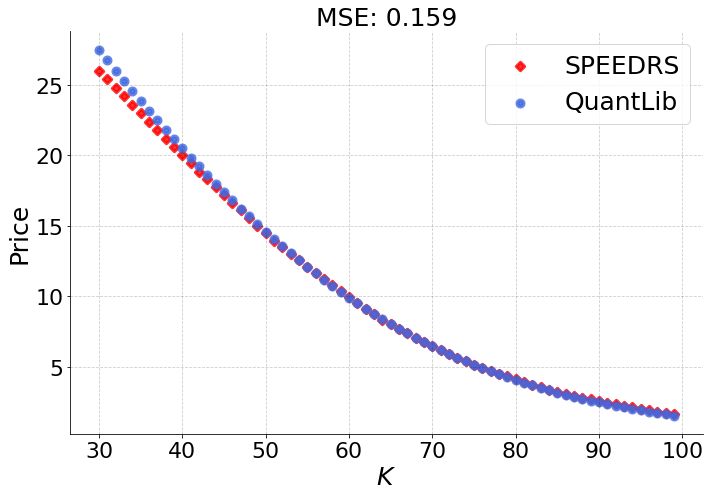

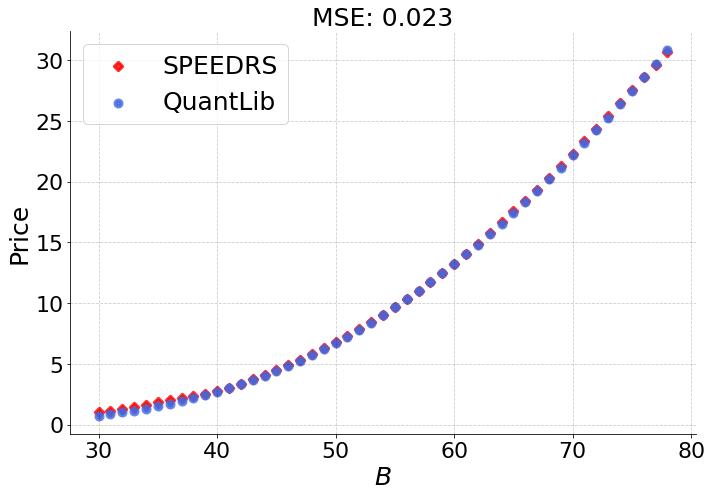

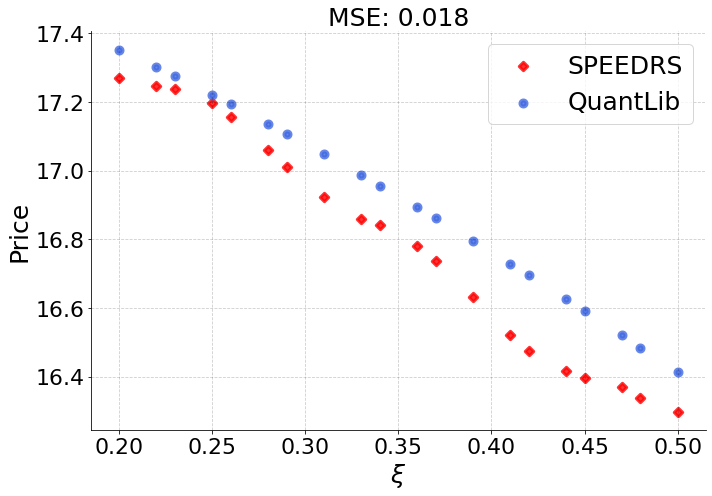

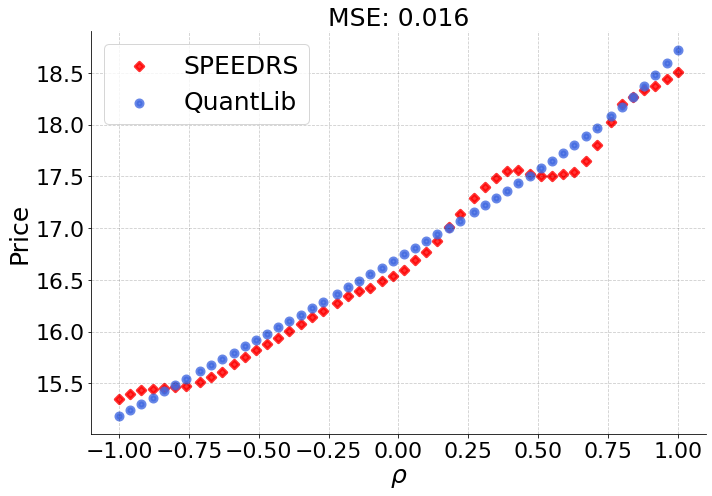

In [12]:
labels = ['SPEEDRS', 'QuantLib']
markers = ['D', 'o']
alphas = [0.8, 0.8]
linewidths = [3.0, 4.0]
colors = ['red', 'royalblue']
ylabel = 'Price'

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Strike'][0], test_data_dict['Strike'][1], test_data_dict['Strike'][2], 
                       labels, markers, colors, alphas, linewidths, r'$K$', ylabel)

plt.tight_layout()
filename = 'Heston/Images/test_plots_K.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Barrier'][0], test_data_dict['Barrier'][1], test_data_dict['Barrier'][2], 
                       labels, markers, colors, alphas, linewidths, r'$B$', ylabel)

plt.tight_layout()
filename = 'Heston/Images/test_plots_B.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()


fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['VolofVol'][0], test_data_dict['VolofVol'][1], test_data_dict['VolofVol'][2], 
                       labels, markers, colors, alphas, linewidths, r'$\xi$', ylabel)

plt.tight_layout()
filename = 'Heston/Images/test_plots_xi.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Correlation'][0], test_data_dict['Correlation'][1], test_data_dict['Correlation'][2], 
                       labels, markers, colors, alphas, linewidths, r'$\rho$', ylabel)

plt.tight_layout()
filename = 'Heston/Images/test_plots_rho.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

## Test Run-Time

In [562]:
%%timeit

T = 3.0
barrier_pricing_model_heston.model.eval()
heston_second_order_mmd_model.model.eval()
with torch.no_grad():
    test_inputs = [heston_second_order_mmd_model.transform(torch.tensor([
                                    v0, heston_down_in_call_barrier_pricing_dict['V0 List'][j],
                                    vol_of_vol, heston_down_in_call_barrier_pricing_dict['Vol of Vols'][j], 
                                    mean_volatility, heston_down_in_call_barrier_pricing_dict['Mean Volatilities'][j],
                                    speed, heston_down_in_call_barrier_pricing_dict['Speeds'][j],
                                    correlation, heston_down_in_call_barrier_pricing_dict['Correlations'][j]]).unsqueeze(0).float()).squeeze(0).squeeze(0)
                            for j in range(heston_down_in_call_barrier_pricing_dict['N'])]
    test_inputs += [s0, strike, r, barrier, T]
    barrier_pricing_model_heston.transform(torch.tensor(test_inputs).unsqueeze(0).float())

16.5 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [563]:
%%timeit

T = 3.0

sample_paths = heston_sample_paths_inv(s0, v0, r, correlation, mean_volatility, speed, vol_of_vol, T, 50000, int(100*T), barrier, strike)[-1]

european_call_monte_carlo_disc(sample_paths, r, strike, T)

2.86 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%%timeit

heston_second_order_mmd_model.model.eval()
with torch.no_grad():
    heston_second_order_mmd_model.transform(torch.tensor([
                                    v0, v0,
                                    vol_of_vol, vol_of_vol, 
                                    mean_volatility, mean_volatility,
                                    speed, speed,
                                    correlation, correlation]).unsqueeze(0).float())

632 µs ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [91]:
static_kernel_21 = RBFKernel(sigma=0.5)
static_kernel_22 = RBFKernel(sigma=0.5)

dyadic_order = 0

lambda_ = 1e-5

signature_kernel = SigKernel([static_kernel_21, static_kernel_22], dyadic_order)

num_sim = 300
num_time_steps = 14

In [93]:
%%timeit

with torch.no_grad():
    path1 = torch.transpose(torch.from_numpy(heston_sample_paths_inv(0.5, v0, 0, correlation, mean_volatility, speed, vol_of_vol, 1, num_sim, num_time_steps)[2]), 0, 1).to(device=device)
    path2 = torch.transpose(torch.from_numpy(heston_sample_paths_inv(0.5, v0, 0, correlation, mean_volatility, speed, vol_of_vol, 1, num_sim, num_time_steps)[2]), 0, 1).to(device=device)
    
    signature_kernel.compute_mmd(path1, path2, lambda_=lambda_, estimator='ub', order=2)

6.45 s ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
